# MAIN

You can neutralize the facial expressions of smiling people with codes below. I have used CK+ dataset while training the Conditional Difference Adversarial AutoEncoder. This model is proposed by Yuqian ZHOU, Bertram Emil SHI. The most important strength of this model is that it does not require too many training pairs to neutralize the face of a person whom it has never seen. For example, while training my model, I have utilized only 59 pairs. 

Before starting if you want to run the code, please make sure that you adjust the folder_adress variable correctly.



In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 30 15:29:55 2019

@author: can
"""
folder_address="/Users/can/Desktop/biometrics_final_shared"

The code chunk below constructs the necessary tensors.

In [2]:
import os
from IPython.display import Image,display
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import matplotlib.image as mpimg
import math
import glob
tf.reset_default_graph()
#%%
#data read

test_percentage=0.15
os.chdir(folder_address)
from numpy import genfromtxt
new_emotional = genfromtxt('flat_emotional.csv', delimiter=',')
emotional_pics=new_emotional.reshape(69,32,32)
nums=np.array([tmp for tmp in range(len(emotional_pics))])
#construct train and test sets
random.seed(4)
random.shuffle(nums)
size_of_test_set=int(len(emotional_pics)*test_percentage)
test_index=nums[:size_of_test_set]

emotional_pics_test=emotional_pics[test_index]
emotional_pics=np.delete(emotional_pics,test_index,0)


new_neutral = genfromtxt('flat_neutral.csv', delimiter=',')
neutral_pics=new_neutral.reshape(69,32,32)
neutral_pics_test=neutral_pics[test_index]
neutral_pics=np.delete(neutral_pics,test_index,0)



#plt.imshow(neutral_pics_test[0], cmap='gray')
#plt.imshow(emotional_pics_test[0], cmap='gray')

#plt.imshow(neutral_pics[0], cmap='gray')
#plt.imshow(emotional_pics[0], cmap='gray')
#%%
batch_size=1
#conv_layer1

filter_size1=5
num_filters1=128

#conv_layer2

filter_size2=5
num_filters2=256

#conv_layer3

filter_size3=5
num_filters3=256

#conv_layer4

filter_size4=5
num_filters4=512

img_size=32
img_size_flat=img_size*img_size
img_shape=(img_size,img_size)
num_channels=1

latent_space=100
#%%
#add new input tensorname. In this way you can give decriptiptive names to the
#tensors
def new_weights(shape,tens_name):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05),name=tens_name)

def new_biases(length,tens_name):
    return tf.Variable(tf.constant(0.05, shape=[length]),name=tens_name)
    
#%%
def new_conv_layer(input,            # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   name_the_block,
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape,tens_name=name_the_block)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters,tens_name=name_the_block)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    
    
    #layer = tf.nn.relu(layer)
    layer = tf.nn.leaky_relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

#%%
    
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

#%%
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 name_the_block,
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs],tens_name=name_the_block)
    biases = new_biases(length=num_outputs,tens_name=name_the_block)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

#%% 
    #bu unpooling upsampling code'unu github'dan buldum nedir ne degildir aramak lazim.
def UnPooling2x2ZeroFilled(x):
    # https://github.com/tensorflow/tensorflow/issues/2169
    out = tf.concat([x, tf.zeros_like(x)], 3)
    out = tf.concat([out, tf.zeros_like(out)], 2)

    sh = x.get_shape().as_list()
    if None not in sh[1:]:
        out_size = [-1, sh[1] * 2, sh[2] * 2, sh[3]]
        return tf.reshape(out, out_size)
    else:
        shv = tf.shape(x)
        ret = tf.reshape(out, tf.stack([-1, shv[1] * 2, shv[2] * 2, sh[3]]))
        return ret    
#%%
def new_deconv_layer(prev_layer,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   target_shape,
                   name_the_block,
                   use_upsampling=True,is_final=False):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_filters, num_input_channels ]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape,tens_name=name_the_block)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters,tens_name=name_the_block)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d_transpose(prev_layer,
                         weights,
                         output_shape=target_shape,
                         #strides=[1, 2, 2, 1],
                         strides=[1, 1, 1, 1],
                         padding='SAME'
                         )
                         
    #int(layer_deconv1.get_shape()[-1])
    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_upsampling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = UnPooling2x2ZeroFilled(layer)

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    
    if is_final==True:
        layer = tf.nn.relu(layer)
    else:
        layer = tf.math.tanh(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

#%%

x = tf.placeholder(tf.float32, shape=[batch_size, img_size,img_size], name='x')

x_image = tf.reshape(x, [batch_size, img_size, img_size, num_channels]) 
#%%


def E1(x_image,num_channels,filter_size1,num_filters1):
    layer_conv1,weights_conv1=new_conv_layer(input=x_image,
                                         num_input_channels=num_channels,
                                         filter_size=filter_size1,
                                         num_filters=num_filters1,
                                         name_the_block="enc",
                                         use_pooling=True
                                         )
    return layer_conv1,weights_conv1

layer_conv1,weights_conv1=E1(x_image,num_channels,filter_size1,num_filters1)
layer_conv1    
    
    
#this operation is done via E1 function.    
#layer_conv1,weights_conv1=new_conv_layer(input=x_image,
#                                         num_input_channels=num_channels,
#                                         filter_size=filter_size1,
#                                         num_filters=num_filters1,
#                                         use_pooling=True
#                                         )
#layer_conv1
#%%

def E2(layer_conv1,num_filters1,num_filters2,num_filters3,filter_size2,
       filter_size3,filter_size4,latent_space):
    layer_conv2, weights_conv2 =new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   name_the_block="enc",
                   use_pooling=True)

    #layer_conv2

    layer_conv3, weights_conv3 =new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   name_the_block="enc",
                   use_pooling=True)

    #layer_conv3

    layer_conv4, weights_conv4 =new_conv_layer(input=layer_conv3,
                   num_input_channels=num_filters3,
                   filter_size=filter_size4,
                   num_filters=num_filters4,
                   name_the_block="enc",
                   use_pooling=False)

    #layer_conv4

    layer_flat,num_features=flatten_layer(layer_conv4)

    latent_real=new_fc_layer(input=layer_flat,
                          num_inputs=num_features,
                          num_outputs=latent_space,
                          name_the_block="enc",
                          use_relu=False)
    #latent_layer
    
    return (layer_conv2, weights_conv2,layer_conv3, weights_conv3,
            layer_conv4, weights_conv4,layer_flat,num_features,
            latent_real)
    
    


"""
layer_conv2, weights_conv2 =new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

layer_conv2

layer_conv3, weights_conv3 =new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)

layer_conv3

layer_conv4, weights_conv4 =new_conv_layer(input=layer_conv3,
                   num_input_channels=num_filters3,
                   filter_size=filter_size4,
                   num_filters=num_filters4,
                   use_pooling=True)

layer_conv4

layer_flat,num_features=flatten_layer(layer_conv4)

latent_layer=new_fc_layer(input=layer_flat,
                          num_inputs=num_features,
                          num_outputs=latent_space,
                          use_relu=False)
latent_layer
"""
#use_relu false dan emin degilim activation function icin arastir paper'i

(layer_conv2, weights_conv2,layer_conv3, weights_conv3,
            layer_conv4, weights_conv4,layer_flat,num_features,
            latent_real)=E2(layer_conv1,num_filters1,num_filters2,num_filters3,filter_size2,
       filter_size3,filter_size4,latent_space)
#%%

def DiscriminatorE(latent_vector,latent_space,reuse=False):
    with tf.variable_scope('DiscriminatorE') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()    
    
        #First Fully Connected Layer
        W_fc1 = tf.get_variable('discE_wfc1', [100, 256], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('discE_bfc1', [256], initializer=tf.constant_initializer(0))
        latent_vector2 = tf.nn.leaky_relu(tf.matmul(latent_vector, W_fc1) + b_fc1)
        
        #Second Fully Connected Layer
        W_fc2 = tf.get_variable('discE_wfc2', [256, 256], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('discE_bfc2', [256], initializer=tf.constant_initializer(0))
        latent_vector3 = tf.nn.leaky_relu(tf.matmul(latent_vector2, W_fc2) + b_fc2)
        
        #Third Fully Connected Layer
        W_fc3 = tf.get_variable('discE_wfc3', [256, 256], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc3 = tf.get_variable('discE_bfc3', [256], initializer=tf.constant_initializer(0))
        latent_vector4 = tf.nn.leaky_relu(tf.matmul(latent_vector3, W_fc3) + b_fc3)
        
        #Last Fully Connected Layer
        W_fc4 = tf.get_variable('discE_wfc4', [256, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc4 = tf.get_variable('discE_bfc4', [1], initializer=tf.constant_initializer(0))
        latent_real_fake = (tf.matmul(latent_vector4, W_fc4) + b_fc4)

    return latent_real_fake
#%%
#latent real_to_decide and latent_fake_to_decide must be sent to
    #tf.nn.sigmoid_cross_entropy_with_logits(logits = latent_real_to_decide, labels = tf.ones_like(Dg))
    #tf.nn.sigmoid_cross_entropy_with_logits(logits = latent_fake_to_decide, labels = tf.ones_like(Dg))
    #you need to think about them, look at gan.py script but you need to work on two lines. 

latent_image_to_decide=DiscriminatorE(latent_real,latent_space) 

latent_norm_dist_placehoder=tf.placeholder(tf.float32, [batch_size, latent_space])

latent_norm_real_to_decide=DiscriminatorE(latent_norm_dist_placehoder,latent_space,reuse=True)
#%%
def G1(latent_real,latent_space):
    FC_d=new_fc_layer(input=latent_real,          # The previous layer.
                     num_inputs=latent_space,     # Num. inputs from prev. layer.
                     num_outputs=4*4*512,    # Num. outputs.
                     name_the_block="dec",
                     use_relu=True)
    FC_d = tf.reshape(FC_d, [batch_size,4, 4, 512])
    
    the_shape=[batch_size,4,4,512]
    
    layer_deconv1,weights_deconv1=new_deconv_layer(FC_d,num_input_channels=512,
                     filter_size=5,num_filters=512,target_shape=the_shape,
                     name_the_block="dec",
                     use_upsampling=True,is_final=False)
    
    the_shape=[batch_size,8,8,256]
    
    layer_deconv2,weights_deconv2=new_deconv_layer(layer_deconv1,num_input_channels=512,
                     filter_size=5,num_filters=256,target_shape=the_shape,
                     name_the_block="dec",
                     use_upsampling=True,is_final=False)
    
    the_shape=[batch_size,16,16,128]
    
    layer_deconv3,weights_deconv3=new_deconv_layer(layer_deconv2,num_input_channels=256,
                     filter_size=5,num_filters=128,target_shape=the_shape,
                     name_the_block="dec",
                     use_upsampling=False,is_final=False)
    
    return FC_d,layer_deconv1,layer_deconv2,layer_deconv3

FC_d,layer_deconv1,layer_deconv2,layer_deconv3=G1(latent_real,latent_space)



#%%
def G2(layer_deconv3,layer_conv1):
    
    forward=layer_deconv3+layer_conv1
    forward=UnPooling2x2ZeroFilled(forward)
    
    the_shape=[batch_size,32,32,1]
    layer_deconv4,weights_deconv4=new_deconv_layer(forward,num_input_channels=128,
                     filter_size=5,num_filters=1,target_shape=the_shape,
                     name_the_block="dec",
                     use_upsampling=False,is_final=True)
    return layer_deconv4


layer_deconv4=G2(layer_deconv3,layer_conv1)


#%%
def conv2d(x, W):
  return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')

def avg_pool_2x2(x):
  return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
#%%
def DiscriminatorG(generated_pic,latent_space,reuse=False):
    with tf.variable_scope('DiscriminatorG') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()    
    
        #First Fully Connected Layer
        DGW_fc1 = tf.get_variable('discG_wfc1', [5,5,1,32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        DGb_fc1 = tf.get_variable('discG_bfc1', [32], initializer=tf.constant_initializer(0))
        generated_pic_conv1 = tf.nn.leaky_relu(conv2d(generated_pic, DGW_fc1) + DGb_fc1)
        generated_pic_pool1 = avg_pool_2x2(generated_pic_conv1)
        
        #Second Fully Connected Layer
        DGW_fc2 = tf.get_variable('discG_wfc2', [5,5,32,64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        DGb_fc2 = tf.get_variable('discG_bfc2', [64], initializer=tf.constant_initializer(0))
        generated_pic_conv2 = tf.nn.leaky_relu(conv2d(generated_pic_pool1, DGW_fc2) + DGb_fc2)
        generated_pic_pool2 = avg_pool_2x2(generated_pic_conv2)
        
        #Third Fully Connected Layer
        DGW_fc3 = tf.get_variable('discG_wfc3', [5,5,64,128], initializer=tf.truncated_normal_initializer(stddev=0.02))
        DGb_fc3 = tf.get_variable('discG_bfc3', [128], initializer=tf.constant_initializer(0))
        generated_pic_conv3 = tf.nn.leaky_relu(conv2d(generated_pic_pool2, DGW_fc3) + DGb_fc3)
        generated_pic_pool3 = avg_pool_2x2(generated_pic_conv3)        
        
        #Last Fully Connected Layer
        DGW_fc4 = tf.get_variable('discG_wfc4', [5,5,128, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        DGb_fc4 = tf.get_variable('discG_bfc4', [128], initializer=tf.constant_initializer(0))
        picture_real_fake = tf.nn.leaky_relu(conv2d(generated_pic_pool3, DGW_fc4) + DGb_fc4)
        
        
        picture_flat,num_features2=flatten_layer(picture_real_fake)
        
        #Last Fully Connected Layer
        DW_fc5 = tf.get_variable('discG_wfc5', [2048, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        Db_fc5 = tf.get_variable('discG_bfc5', [1], initializer=tf.constant_initializer(0))
        picture_real_fake_decision = (tf.matmul(picture_flat, DW_fc5) + Db_fc5)
        
        
        
        

    return picture_real_fake_decision



#%%
produced_image_to_decide=DiscriminatorG(layer_deconv4,latent_space) 

actual_output_image_placehoder=tf.placeholder(tf.float32, [batch_size, 32,32,1])

actual_image_to_decide=DiscriminatorG(actual_output_image_placehoder,latent_space,reuse=True)    



#%%
#declare the losses

#Discriminator G
Disc_G_loss_real=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = actual_image_to_decide, labels = tf.ones_like(actual_image_to_decide)))
Disc_G_loss_produced=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = produced_image_to_decide, labels = tf.zeros_like(produced_image_to_decide)))
Loss_Disc_G=Disc_G_loss_real+Disc_G_loss_produced


#Discriminator E
Disc_E_loss_real=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = latent_norm_real_to_decide, labels = tf.ones_like(latent_norm_real_to_decide)))
Disc_E_loss_from_picture=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = latent_image_to_decide, labels = tf.zeros_like(latent_image_to_decide)))
Loss_Disc_E=Disc_E_loss_real+Disc_E_loss_from_picture

##E1E2loss
E1E2_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = latent_image_to_decide, labels = tf.ones_like(latent_image_to_decide))) # ensure forward compatibility: function needs to have logits and labels args explicitly used

##D1D2loss
D1D2_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = produced_image_to_decide, labels = tf.ones_like(produced_image_to_decide))) # ensure forward compatibility: function needs to have logits and labels args explicitly used

#L2 loss between produced image and real desired image

#L2_loss = tf.nn.l2_loss(actual_output_image_placehoder - layer_deconv4)
#L2_loss = 1-tf.image.ssim(actual_output_image_placehoder,layer_deconv4,max_val=255)
L2_loss = tf.reduce_mean(tf.square(actual_output_image_placehoder - layer_deconv4))



#%%

tvars = tf.trainable_variables()
d_vars_E = [var for var in tvars if 'discE' in var.name]
d_vars_G = [var for var in tvars if 'discG' in var.name]
enc_vars = [var for var in tvars if 'enc' in var.name]
dec_vars = [var for var in tvars if 'dec' in var.name]
#%%

loss_ED = (L2_loss * 1) + (E1E2_loss * 0.01) + (D1D2_loss * 0.001)
loss_Disc_E_in_obj = Loss_Disc_E * 0.01
loss_Disc_G_in_obj = Loss_Disc_G * 0.001
#%%
adamautoenc = tf.train.AdamOptimizer(learning_rate=0.001)
adamdisc    = tf.train.AdamOptimizer(learning_rate=0.0001) 

trainer_autoenc=adamautoenc.minimize(loss_ED,var_list=enc_vars + dec_vars)
trainer_discE=adamdisc.minimize(loss_Disc_E_in_obj,var_list=d_vars_E)
trainer_discG=adamdisc.minimize(loss_Disc_G_in_obj,var_list=d_vars_G)

Instructions for updating:
Colocations handled automatically by placer.


Necessary tensors are constructed, now we can start the training. By setting the value of "iterations" variable to a huge number in the code chunk below, you can train the model. Note that training will take considerable amount of time. I have set it to 1 in the code chunk in order to show that the model can be trained. However, while neutralizing the faces, I will utilize the model that I have already constructed. Hence, if you want to run this model on your own image set, you should train your model.

In [3]:
#%%
    #now batch size=1, you have to feed the pictures randomly, and 
    #regulate the update order of autoenc and discriminators.
sess = tf.Session()
sess.run(tf.global_variables_initializer())
iterations = 1
how_many_with_this_batch_size=int(len(emotional_pics)/batch_size)
counter=0
disc_update=False
average_train_error=np.array(0)
average_test_error=np.array(0)
for i in range(iterations):
    #print i
    counter=0
    nums=np.array([tmp for tmp in range(len(emotional_pics))])
    random.shuffle(nums)
    train_error_generator=np.zeros(len(emotional_pics))
    test_error_generator=np.zeros(len(emotional_pics_test))
    for j in range(how_many_with_this_batch_size):
        #print j
        focused=nums[counter:(counter+batch_size)]
        real_image_input=emotional_pics[focused,]
        real_image_input  = real_image_input.reshape(batch_size,32,32)
        real_image_output = neutral_pics[focused,]
        real_image_output  = real_image_output.reshape(batch_size,32,32,1)        
        latent_normal=np.random.normal(0,1,100*batch_size)
        #latent_normal=np.random.uniform(-1,1,100*batch_size)
        latent_normal=latent_normal.reshape(batch_size,100)
        if disc_update== True:
            _,loss_Disc_G_follow = sess.run([trainer_discG, loss_Disc_G_in_obj],feed_dict={x:real_image_input,actual_output_image_placehoder:real_image_output}) #Update the discriminatorG
            _,loss_Disc_E_follow = sess.run([trainer_discE, loss_Disc_E_in_obj],feed_dict={latent_norm_dist_placehoder:latent_normal,x:real_image_input}) #Update the discriminatorE
            disc_update=False            
        else:
            _,loss_ED_follow = sess.run([trainer_autoenc, loss_ED],feed_dict={x:real_image_input,actual_output_image_placehoder:real_image_output}) #Update the autoenc 
            disc_update=True
        #train_error_generator[j]=loss_ED_follow  
              
               
        counter=counter+batch_size

    counter=0
    for j in range(how_many_with_this_batch_size):
        #print j
        focused=nums[counter:(counter+batch_size)]
        real_image_input=emotional_pics[focused,]
        real_image_input  = real_image_input.reshape(batch_size,32,32)
        real_image_output = neutral_pics[focused,]
        real_image_output  = real_image_output.reshape(batch_size,32,32,1)        
        latent_normal=np.random.normal(0,1,100*batch_size)
        #latent_normal=np.random.uniform(-1,1,100*batch_size)
        latent_normal=latent_normal.reshape(batch_size,100)
        
        #_,loss_Disc_G_follow = sess.run([trainer_discG, loss_Disc_G_in_obj],feed_dict={x:real_image_input,actual_output_image_placehoder:real_image_output}) #Update the discriminatorG
        #_,loss_Disc_E_follow = sess.run([trainer_discE, loss_Disc_E_in_obj],feed_dict={latent_norm_dist_placehoder:latent_normal,x:real_image_input}) #Update the discriminatorE
                        
        
        train_error_generator[j] = sess.run(loss_ED,feed_dict={x:real_image_input,actual_output_image_placehoder:real_image_output}) #train loss 
            
        #train_error_generator[j]=loss_ED_follow  
              
               
        counter=counter+batch_size


    for j in range(len(emotional_pics_test)):
        #print j
        real_image_input=emotional_pics_test[j,]
        real_image_input  = real_image_input.reshape(batch_size,32,32)
        real_image_output = neutral_pics_test[j,]
        real_image_output  = real_image_output.reshape(batch_size,32,32,1)        
        latent_normal=np.random.normal(0,1,100*batch_size)
        #latent_normal=np.random.uniform(-1,1,100*batch_size)
        latent_normal=latent_normal.reshape(batch_size,100)
        
        #_,loss_Disc_G_follow = sess.run([trainer_discG, loss_Disc_G_in_obj],feed_dict={x:real_image_input,actual_output_image_placehoder:real_image_output}) #Update the discriminatorG
        #_,loss_Disc_E_follow = sess.run([trainer_discE, loss_Disc_E_in_obj],feed_dict={latent_norm_dist_placehoder:latent_normal,x:real_image_input}) #Update the discriminatorE
                        
        
        test_error_generator[j] = sess.run(loss_ED,feed_dict={x:real_image_input,actual_output_image_placehoder:real_image_output}) #train loss
        
     
    print "train error:"
    average_train_error=np.append(average_train_error,np.mean(train_error_generator))
    print (average_train_error[i+1])
    print "test error:"
    average_test_error=np.append(average_test_error,np.mean(test_error_generator))
    print (average_test_error[i+1])
    #if average_test_error[i+1] < 0.17: if you are using SSIM as loss function
    if average_test_error[i+1] < 500 and average_train_error[i+1] < 500 :
    #if average_test_error[i+1] < 480:
      break
#%%



train error:
1626.9681137860832
test error:
1558.1762451171876


Training is done.  As I already explained, instead of training the model from scratch, I will directly utilize the model on my computer.

In [4]:
saver = tf.train.Saver()
os.chdir(folder_address + "/trained_model/average_tr_te_error_less500")
#os.chdir(folder_address + "/trained_model/overfit")
saver.restore(sess, "modelfinal.ckpt")
#saver.restore(sess, "modeloverfit.ckpt")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from modelfinal.ckpt


The weights in the model are set. Let' s define some functions in order to visualize the images.

In [5]:
def visualize_wild_image(index,folder_address):
    instances = glob.glob(folder_address+"/wild_sample_images_preprocessed//*")
    inst=instances[index]
    wild_img = cv2.imread(inst,cv2.IMREAD_GRAYSCALE)
    plt.imshow(wild_img, cmap='gray')

def wild_image_neutralize(index,folder_address):
    instances = glob.glob(folder_address+"/wild_sample_images_preprocessed//*")
    inst=instances[index]
    wild_img = cv2.imread(inst,cv2.IMREAD_GRAYSCALE)
    wild_img=wild_img.reshape(batch_size,32,32)
    temp=sess.run(layer_deconv4, feed_dict={x:wild_img})
    my_i = temp.squeeze()
    plt.imshow(my_i, cmap='gray')
    
def save_wild(index,folder_address):
    instances = glob.glob(folder_address+"/wild_sample_images_preprocessed//*")
    inst=instances[index]
    tmp_name=inst[-6:]
    if tmp_name[0]!="/":
        tmp_name=int(tmp_name[:2])
    else:
        tmp_name=int(tmp_name[1])
        
    
    wild_img = cv2.imread(inst,cv2.IMREAD_GRAYSCALE)
    wild_img=wild_img.reshape(batch_size,32,32)
    temp=sess.run(layer_deconv4, feed_dict={x:wild_img})
    my_i = temp.squeeze()
    cv2.imwrite(folder_address+"/wild_neutralized/"+str(tmp_name)+"generated.png",my_i)
    

def visualize_produced_image_train(tr_index):
    real_image_input=emotional_pics[tr_index,]
    real_image_input  = real_image_input.reshape(batch_size,32,32)
    temp=sess.run(layer_deconv4, feed_dict={x:real_image_input})
    my_i = temp.squeeze()
    plt.imshow(my_i, cmap='gray')
    
def visualize_produced_image_test(te_index):
    real_image_input=emotional_pics_test[te_index,]
    real_image_input  = real_image_input.reshape(batch_size,32,32)
    temp=sess.run(layer_deconv4, feed_dict={x:real_image_input})
    my_i = temp.squeeze()
    plt.imshow(my_i, cmap='gray')
    
def save_tr_images(tr_index):
    real_image_input=emotional_pics[tr_index,]
    real_image_input  = real_image_input.reshape(batch_size,32,32)
    temp=sess.run(layer_deconv4, feed_dict={x:real_image_input})
    my_i = temp.squeeze()
    cv2.imwrite(folder_address+"/images_for_progress/realmodel/tr/"+str(tr_index)+"generated.png",my_i)
    cv2.imwrite(folder_address+"/images_for_progress/realmodel/tr/"+str(tr_index)+"emotional.png",emotional_pics[tr_index,])    
    cv2.imwrite(folder_address+"/images_for_progress/realmodel/tr/"+str(tr_index)+"neutral.png",neutral_pics[tr_index,])
    
def save_te_images(te_index):
    real_image_input=emotional_pics_test[te_index,]
    real_image_input  = real_image_input.reshape(batch_size,32,32)
    temp=sess.run(layer_deconv4, feed_dict={x:real_image_input})
    my_i = temp.squeeze()
    cv2.imwrite(folder_address+"/images_for_progress/realmodel/test/"+str(te_index)+"generated.png",my_i)
    cv2.imwrite(folder_address+"/images_for_progress/realmodel/test/"+str(te_index)+"emotional.png",emotional_pics_test[te_index,])    
    cv2.imwrite(folder_address+"/images_for_progress/realmodel/test/"+str(te_index)+"neutral.png",neutral_pics_test[te_index,])
#%%



Let's look at a person from training set.
Below, there is an image of smiling person.

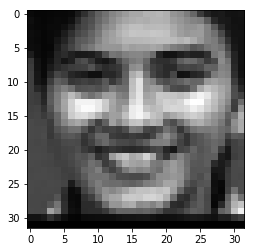

In [23]:
#%%
#TRAINIG   
tr_ind=23
#emotional train sample
plt.imshow(emotional_pics[tr_ind,], cmap='gray')

Now, let' s look at the original neutral expression of this person.

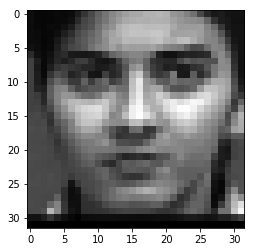

In [24]:
#neutral train sample
plt.imshow(neutral_pics[tr_ind,], cmap='gray')

Finally, the generated image by the model.

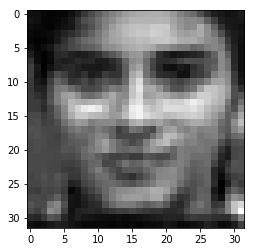

In [25]:
#neutralized train sample
visualize_produced_image_train(tr_ind)

As you can see, model can neutralize the expression of person successfully. However, This person was in the training set. Let' s also look at an example from the test set.

Here is the original smiling person whom model has not seen before.

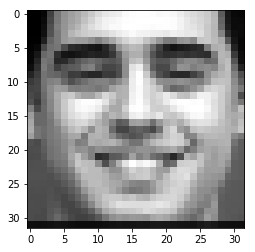

In [26]:
#TEST
te_ind=6
#emotional test sample
plt.imshow(emotional_pics_test[te_ind,], cmap='gray')

Now, let' s look at the original neutral expression of this person.

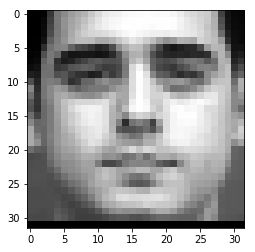

In [27]:
#neutral test sample
plt.imshow(neutral_pics_test[te_ind,], cmap='gray')

Finally, the generated image by the model.

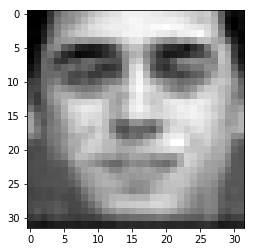

In [28]:
#neutralized test sample
visualize_produced_image_test(te_ind)

Despite small artifacts, the expression is neutralized. However, the model is not always good at neutralizing the faces of person who are in the test set. Another example;

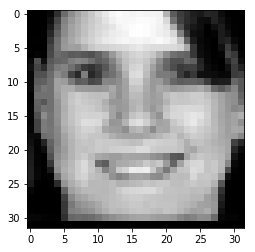

In [35]:
#TEST
te_ind=0
#emotional test sample
plt.imshow(emotional_pics_test[te_ind,], cmap='gray')

Now, let' s look at the original neutral expression of this person.

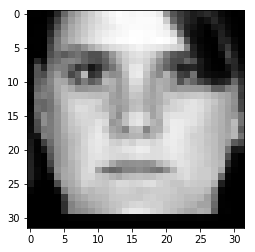

In [36]:
#neutral test sample
plt.imshow(neutral_pics_test[te_ind,], cmap='gray')

Finally, the generated image by the model.

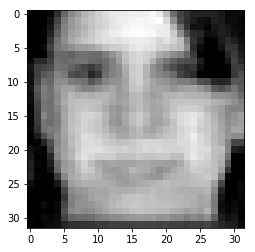

In [37]:
#neutralized test sample
visualize_produced_image_test(te_ind)

This time model disrupts the image considerably while neutralizing the expression. Additionally, there are some cases in which model cannot neutralize the expression. 

All these images can be found in CK+ database. Note that they were taken in a controlled environment. It would be also interesting to see the capability of model for wild pictures. Below you can see the original picture.

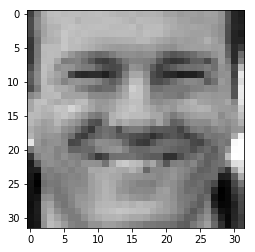

In [42]:
#WILD
visualize_wild_image(2,folder_address)

Neutralized picture can be seen below.

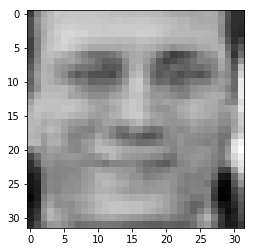

In [43]:
wild_image_neutralize(2,folder_address)

Another original and generated picture can be seen below.

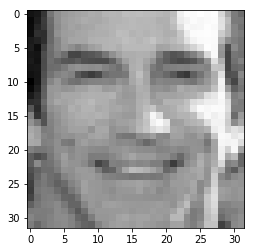

In [49]:
visualize_wild_image(5,folder_address)

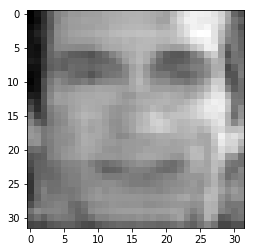

In [50]:
wild_image_neutralize(5,folder_address)

This is the last example. Nevertheless, the model cannot neutralize it properly. Probably, the beard of person prevented the model from neutralizing the expression.

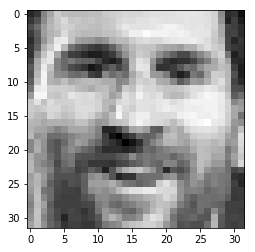

In [64]:
visualize_wild_image(16,folder_address)

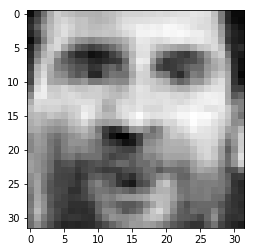

In [65]:
wild_image_neutralize(16,folder_address)

save_tr_images(),save_te_images() functions are used to save images that are included to report, when you want to use them again, carefully adjust the saving path for pictures. Otherwise,you will create a mess.

In [52]:
save_tr_images(30)
save_tr_images(50)
save_tr_images(27)

save_te_images(2)
save_te_images(4)
save_te_images(6)
save_te_images(9)


save_wild(0,folder_address)
save_wild(1,folder_address)
save_wild(2,folder_address)
save_wild(3,folder_address)
save_wild(4,folder_address)
save_wild(5,folder_address)
save_wild(6,folder_address)
save_wild(7,folder_address)
save_wild(8,folder_address)
save_wild(9,folder_address)
save_wild(10,folder_address)
save_wild(11,folder_address)
save_wild(12,folder_address)
save_wild(13,folder_address)
save_wild(14,folder_address)
save_wild(15,folder_address)
save_wild(16,folder_address)

# References
Zhou, Yuqian, and Bertram Emil Shi. “Photorealistic Facial Expression Synthesis by the Conditional Difference Adversarial Autoencoder.” 2017 Seventh International Conference on Affective Computing and Intelligent Interaction (ACII), 2017, doi:10.1109/acii.2017.8273626.Age Progression/Regression by Conditional Adversarial Autoencoder 

Zhang, Zhifei, et al. “Age Progression/Regression by Conditional Adversarial Autoencoder.” 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2017, doi:10.1109/cvpr.2017.463.

Lucey, P., Cohn, J. F., Kanade, T., Saragih, J., Ambadar, Z., & Matthews, I. (2010). The Extended Cohn-Kanade Dataset (CK+): A complete expression dataset for action unit and emotion-specified expression. Proceedings of the Third International Workshop on CVPR for Human Communicative Behavior Analysis (CVPR4HB 2010), San Francisco, USA, 94-101.

“Generative Adversarial Networks Using Tensorflow.” Towards Data Science, Towards Data Science, 28 Aug. 2018, towardsdatascience.com/generative-adversarial-networks-using-tensorflow-c8f4518406df.


Michael J. Lyons, Shigeru Akamatsu, Miyuki Kamachi, Jiro Gyoba.
Coding Facial Expressions with Gabor Wavelets, 3rd IEEE International Conference on Automatic Face and Gesture Recognition, pp. 200-205 (1998).
http://doi.org/10.1109/AFGR.1998.670949


Liu, Z., Luo, P., Wang, X., and Tang, X. Deep learning face attributes in the wild. In Proceedings of the IEEE International Conference on Computer Vision, pp. 3730– 3738, 2015.
